**Input:** 
- UK Biobank cancer-related fields
- ACCEL dataset (Katori et al. 2022)


**Process:**
 - Extract the subset population with ACCEL dataset available
 - See whether cancer makes any difference in ACCEL features

**Output:**


# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [2]:
import collections
import csv
from datetime import datetime
import os
import numpy as np
import pandas as pd
from pathlib import Path
import polars as pl
import re
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt

from scipy.stats import chi2_contingency

import statsmodels.api as sm

from contextlib import redirect_stdout
from io import StringIO

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Draw flowcharts using Mermaid
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))


dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


In [4]:
DIR_SOURCE = os.path.join("data", "accel_ukbb", "split")
DIR_OUT = os.path.join("analysis", "specific", "analysis_20230419_01_ACCEL_cancer")

if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

In [428]:
mm("""
graph TD;
    UKBB[UKBB population: 502,386] --> ACCEL[ACCEL data available: 81,496];
    ACCEL --> C1[cancer record after accelerometry: 6,098];
    ACCEL --> C2[cancer record before accelerometry: 11,684];
    ACCEL --> C3[no cancer record: 63,714];
""")


## Functions

In [5]:
def merge_files(list_files, dir):
    list_files = [os.path.join(dir, file) for file in list_files]

    # Initialize an empty DataFrame
    df_merged = pl.DataFrame()
    
    print(datetime.now(), "Start processing", len(list_files), "files")

    # Loop over each file in the list and add it to the merged DataFrame
    for i, file in enumerate(list_files):
        func_print(i + 1)
        # Read in the current file as a DataFrame
        df_current = pl.read_csv(file, sep="\t")

        # Get the column name for the current file's specific column
        column_name = os.path.splitext(os.path.basename(file))[0]

        # Rename the specific column to the name of the current file
        #df_current = df_current.rename(columns={df_current.columns[1]: column_name})
        df_current = df_current.rename({df_current.columns[1]: column_name})

        # If this is the first file being added, simply set df_merged to df_current
        if df_merged.shape == (0, 0):
            df_merged = df_current

        # Otherwise, merge df_current with df_merged on the "eid" column
        else:
            df_merged = df_merged.join(df_current, on="eid", how="outer")

    return df_merged
    
    

def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")


# Merge the relevant fields

In [ ]:
list_files = [
"ukb671006_22286_40005-0.0.txt",
"ukb671006_22287_40005-1.0.txt",
"ukb671006_22288_40005-2.0.txt",
"ukb671006_22289_40005-3.0.txt",
"ukb671006_22290_40005-4.0.txt",
"ukb671006_22291_40005-5.0.txt",
"ukb671006_22292_40005-6.0.txt",
"ukb671006_22293_40005-7.0.txt",
"ukb671006_22294_40005-8.0.txt",
"ukb671006_22295_40005-9.0.txt",
"ukb671006_22296_40005-10.0.txt",
"ukb671006_22297_40005-11.0.txt",
"ukb671006_22298_40005-12.0.txt",
"ukb671006_22299_40005-13.0.txt",
"ukb671006_22300_40005-14.0.txt",
"ukb671006_22301_40005-15.0.txt",
"ukb671006_22302_40005-16.0.txt",
"ukb671006_22303_40005-17.0.txt",
"ukb671006_22304_40005-18.0.txt",
"ukb671006_22305_40005-19.0.txt",
"ukb671006_22306_40005-20.0.txt",
"ukb671006_22307_40005-21.0.txt",
"ukb671006_24430_90010-0.0.txt",
"ukb671006_28448_eid_old.txt",
"ukb671006_28449_day_num.txt",
"ukb671006_28450_ST_long_mean.txt",
"ukb671006_28451_ST_long_sd.txt",
"ukb671006_28452_WT_long_mean.txt",
"ukb671006_28453_WT_long_sd.txt",
"ukb671006_28454_ST_short_mean.txt",
"ukb671006_28455_ST_short_sd.txt",
"ukb671006_28456_WT_short_mean.txt",
"ukb671006_28457_WT_short_sd.txt",
"ukb671006_28458_long_window_len_mean.txt",
"ukb671006_28459_long_window_len_sd.txt",
"ukb671006_28460_long_window_num_mean.txt",
"ukb671006_28461_long_window_num_sd.txt",
"ukb671006_28462_short_window_len_mean.txt",
"ukb671006_28463_short_window_len_sd.txt",
"ukb671006_28464_short_window_num_mean.txt",
"ukb671006_28465_short_window_num_sd.txt",
"ukb671006_28466_phase_mean.txt",
"ukb671006_28467_phase_sd.txt",
"ukb671006_28468_max_period.txt",
"ukb671006_28469_amplitude.txt",
"ukb671006_28470_sleep_percentage.txt",
"ukb671006_28471_continuous_day.txt",
"ukb671006_28472_age.txt",
"ukb671006_28473_sex.txt",
"ukb671006_28474_cluster.txt",
"ukb671006_28475_group_eid_old.txt",
"ukb671006_28476_abnormal_group_eid_old.txt",
"ukb671006_28479_cluster_alphabet.txt",
"ukb671006_28480_group_five.txt",
"ukb671006_28481_group_eight.txt",
"ukb671006_28482_abnormal_group_eight.txt",]
df = merge_files(list_files, DIR_SOURCE)

2023-04-24 11:47:45.471587 Start processing 56 files
2023-04-24 11:47:45: 1
2023-04-24 11:47:47: 2
2023-04-24 11:47:51: 3
2023-04-24 11:47:57: 4
2023-04-24 11:48:02: 5
2023-04-24 11:48:06: 6
2023-04-24 11:48:12: 7
2023-04-24 11:48:16: 8
2023-04-24 11:48:21: 9
2023-04-24 11:48:25: 10


In [ ]:
df

# Date of cancer diagnosis
- Calculate the earliest date of cancer diagnosis
- Flag whether the cancer diagnosis is before or after the accelerometry measurement

In [ ]:
cols_cancer_date = [
"ukb671006_22286_40005-0.0", 
"ukb671006_22287_40005-1.0", 
"ukb671006_22288_40005-2.0", 
"ukb671006_22289_40005-3.0", 
"ukb671006_22290_40005-4.0", 
"ukb671006_22291_40005-5.0", 
"ukb671006_22292_40005-6.0", 
"ukb671006_22293_40005-7.0", 
"ukb671006_22294_40005-8.0", 
"ukb671006_22295_40005-9.0", 
"ukb671006_22296_40005-10.0", 
"ukb671006_22297_40005-11.0", 
"ukb671006_22298_40005-12.0", 
"ukb671006_22299_40005-13.0", 
"ukb671006_22300_40005-14.0", 
"ukb671006_22301_40005-15.0", 
"ukb671006_22302_40005-16.0", 
"ukb671006_22303_40005-17.0", 
"ukb671006_22304_40005-18.0", 
"ukb671006_22305_40005-19.0", 
"ukb671006_22306_40005-20.0", 
"ukb671006_22307_40005-21.0", 
]

# convert the columns to Date
for i_col in cols_cancer_date:
    df = df.with_columns(pl.col(i_col).str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False))
    
# calculate the earliest date for each row
earliest_cancer = df[cols_cancer_date].min(axis=1)

# Preserve only the earliest date
df = df.with_column(earliest_cancer.alias("earliest_cancer")).drop(cols_cancer_date)

# Convert the row "ukb671006_24430_90010-0.0"
#    (ACCEL date stored in UKBiobank)
#    to date format

# Define the custom date conversion function
def convert_date_format(date_str: str) -> str:
    if date_str == "NA":
        formatted_date = "NA"
    else:
        date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
        formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date


# Apply the custom function to the "ukb671006_24430_90010-0.0" column
df = (df.with_column(
    pl.col("ukb671006_24430_90010-0.0")
    .apply(convert_date_format, return_dtype=pl.Utf8)
    .str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False)
    .alias("ukb671006_24430_90010-0.0")
))

df

In [ ]:
# Define a function to convert the date string into a single integer
def date_string_to_int(date_str):
    if not date_str:
        result = "NA"
    else:
        date_start = datetime.strptime("1970-10-10", '%Y-%m-%d').date()
        result = (date_str - date_start).days
    return result


accel_after_cancer = (df['ukb671006_24430_90010-0.0'] > df['earliest_cancer']).cast(pl.Boolean)

df_annotated = (df
                .with_column(accel_after_cancer.alias("accel_after_cancer"))
                .with_columns(pl.col('ukb671006_24430_90010-0.0')
                              .apply(date_string_to_int)
                              .alias("ukb671006_24430_90010-0.0_days")
                              .cast(pl.Int32, strict=False)
                             )
                .with_columns(pl.col('earliest_cancer')
                              .apply(date_string_to_int)
                              .alias("earliest_cancer_days")
                              .cast(pl.Int32, strict=False)
                             )                              
               )
df_annotated

In [ ]:
FILE_OUT = os.path.join(DIR_OUT, "filtered_annotated.csv")
df_annotated.write_csv(FILE_OUT)

# Comparison of "accelerometry before/after/without cancer" - overall chisq/t-test

In [ ]:
file = os.path.join(DIR_OUT, "filtered_annotated.csv")
df_annotated = (pl.read_csv(file, infer_schema_length=None)
               .filter(pl.col("ukb671006_28448_eid_old") != "NA")
               )
df_annotated

In [ ]:
df_accel_before_cancer = df_annotated.filter(pl.col("accel_after_cancer") == False)
df_accel_after_cancer = df_annotated.filter(pl.col("accel_after_cancer") == True)
df_accel_with_cancer = df_annotated.filter(pl.col("accel_after_cancer").is_not_null())
df_accel_without_cancer = df_annotated.filter(pl.col("accel_after_cancer").is_null())

In [ ]:
df_accel_after_cancer

In [ ]:
df_accel_before_cancer

In [ ]:
df_accel_with_cancer

In [ ]:
df_accel_without_cancer

In [447]:
pheno_list_categorical = [
"ukb671006_28449_day_num",
"ukb671006_28471_continuous_day",
"ukb671006_28473_sex",
"ukb671006_28474_cluster",
"ukb671006_28475_group_eid_old",
"ukb671006_28476_abnormal_group_eid_old",
"ukb671006_28480_group_five",
]

pheno_list_continuous = [
"ukb671006_28450_ST_long_mean",
"ukb671006_28451_ST_long_sd",
"ukb671006_28452_WT_long_mean",
"ukb671006_28453_WT_long_sd",
"ukb671006_28454_ST_short_mean",
"ukb671006_28455_ST_short_sd",
"ukb671006_28456_WT_short_mean",
"ukb671006_28457_WT_short_sd",
"ukb671006_28458_long_window_len_mean",
"ukb671006_28459_long_window_len_sd",
"ukb671006_28460_long_window_num_mean",
"ukb671006_28461_long_window_num_sd",
"ukb671006_28462_short_window_len_mean",
"ukb671006_28463_short_window_len_sd",
"ukb671006_28464_short_window_num_mean",
"ukb671006_28465_short_window_num_sd",
"ukb671006_28466_phase_mean",
"ukb671006_28467_phase_sd",
"ukb671006_28468_max_period",
"ukb671006_28469_amplitude",
"ukb671006_28470_sleep_percentage",
"ukb671006_28472_age",
"ukb671006_24430_90010-0.0_days",
"earliest_cancer_days",
]

# Process categorical variables
def compare_categorical(pheno_list_categorical, df1, df2, label1, label2):
    list_statistics = [["data1", "data2", "phenotype", "chi-sq", "p-value"]] # Store the result
    for pheno in pheno_list_categorical:
        print(pheno)
        # List up the frequency of each value in a column of the two dataframes
        freq_before = df1[pheno].value_counts().sort(by=pheno)
        freq_after = df2[pheno].value_counts().sort(by=pheno)

        # Print the frequency of each value
        # Create a contingency table of the frequencies
        cont_table = (freq_before.join(freq_after, on=pheno, how='outer')
                      .to_numpy()[:, 1:])
        cont_table = np.nan_to_num(cont_table.astype(float), nan=0).astype(int)
        #print(cont_table)

        # Perform the chi-squared test of independence
        chi2, p_value, dof, expected = chi2_contingency(cont_table)
        list_statistics.append([label1, label2, pheno, chi2, p_value])

        # Print the results of the test
        print("p-value:", p_value)

        # Normalize the data by dividing each row by the row sum
        normalized_cont_table = cont_table / cont_table.sum(axis=0)

        if len(freq_before[pheno]) < len(freq_after[pheno]):
            ticks=freq_after[pheno]
        else:
            ticks=freq_before[pheno]
        
        # Create a bar chart of the normalized data
        fig, ax = plt.subplots()
        fig.set_size_inches(4, 3)
        plt.title(pheno)
        ax.bar(np.arange(normalized_cont_table.shape[0]) - 0.2, normalized_cont_table[:, 0], width=0.4, label=label1)
        ax.bar(np.arange(normalized_cont_table.shape[0]) + 0.2, normalized_cont_table[:, 1], width=0.4, label=label2)
        ax.set_xticks(np.arange(normalized_cont_table.shape[0]))
        ax.set_xticklabels(ticks, rotation='vertical')
        ax.set_xlabel("Values")
        ax.set_ylabel("Normalized values")
        ax.legend()

        plt.show()

        print()
    return list_statistics

        
# Convert anything to np.float32
def pl_to_float(df):
    result = df.to_numpy()
    try:
        result = result.astype(float)
    except:
        if "-" in result[0]: # Date-time format
            # Convert the date strings to datetime objects
            result = np.array([datetime.fromisoformat(date_str) for date_str in result])

            # Extract the date component and convert to integer
            result = np.array([int(date_obj.timestamp()) for date_obj in result])
    return result

# Process continuous variables
def compare_continuous(pheno_list_continuous, df1, df2, label1, label2):
    list_statistics = [["data1", "data2", "phenotype", "t-stat", "p-value"]] # Store the result
    for pheno in pheno_list_continuous:
        print(pheno)

        # Calculate mean, median, and standard deviation for the two dataframes
        try:
            np_before = pl_to_float(df1[pheno])
            np_after = pl_to_float(df2[pheno])
            np_before = np_before[~np.isnan(np_before)]
            np_after = np_after[~np.isnan(np_after)]
        except:
            print("Skip because the matching data does not exist in both datasets")
            continue
        
        if len(np_before) < 10:
            print("Skip because the matching data does not exist in both datasets")
            continue
        if len(np_after) < 10:
            print("Skip because the matching data does not exist in both datasets")
            continue
        
        mean_before = np_before.mean()
        median_before = np.median(np_before)
        std_before = np_before.std()

        mean_after = np_after.mean()
        median_after = np.median(np_after)
        std_after = np_after.std()

        # Perform a two-sample t-test to test for significant differences between the two distributions
        t_stat, p_value = ttest_ind(np_before, np_after, equal_var=False)
        
        list_statistics.append([label1, label2, pheno, t_stat, p_value])

    #    print("Accelerometry before cancer")
    #    print("Mean: {}, Median: {}, SD: {}".format(mean_before, median_before, std_before))
    #    print("Accelerometry after cancer")
    #    print("Mean: {}, Median: {}, SD: {}".format(mean_after, median_after, std_after))
        print("p-value:", p_value)

        # Plot the distribution of the pheno column for each dataframe
        plt.figure(figsize=[4, 3])
        plt.hist(np_before, alpha=0.5, label=label1, density=True, bins=100)
        plt.hist(np_after, alpha=0.5, label=label2, density=True, bins=100)
        plt.legend(loc="upper right")
        plt.title(pheno)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()
    return list_statistics

ukb671006_28449_day_num
p-value: 0.8171067593880471


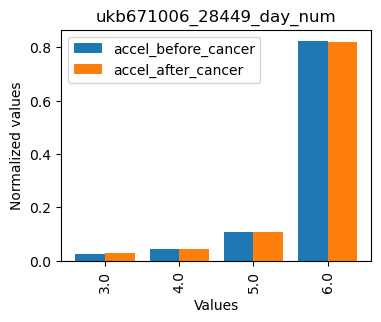


ukb671006_28471_continuous_day
p-value: 0.8567848760513868


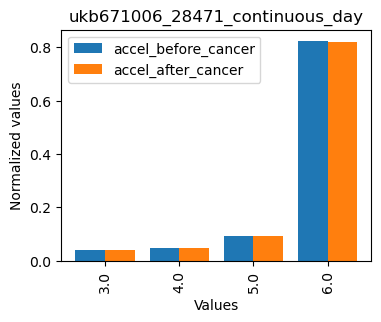


ukb671006_28473_sex
p-value: 1.6118503744238425e-59


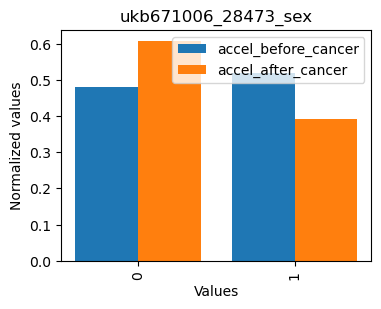


ukb671006_28474_cluster
p-value: 0.46206142412301854


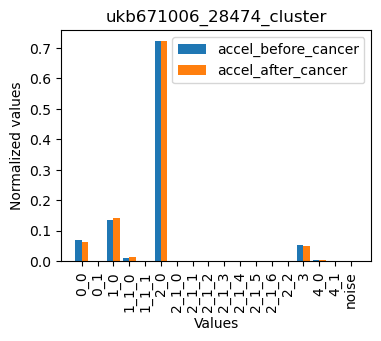


ukb671006_28475_group_eid_old
p-value: 0.09028272458300872


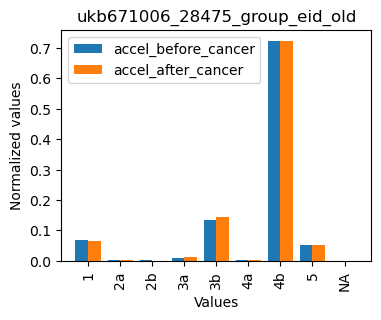


ukb671006_28476_abnormal_group_eid_old
p-value: 0.21104276497484195


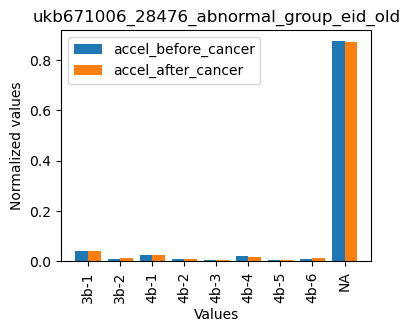


ukb671006_28480_group_five
p-value: 0.1170899068051632


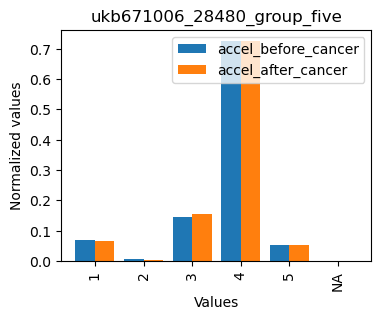

In [442]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_before_cancer, df_accel_after_cancer, 
                    "accel_before_cancer", "accel_after_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_categorical_before_after.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28449_day_num
p-value: 2.7443037784254774e-08


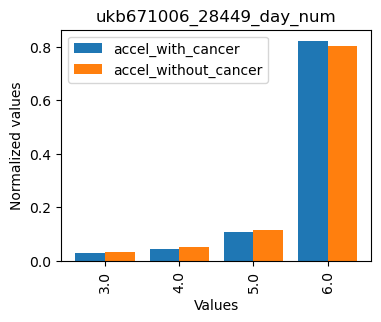


ukb671006_28471_continuous_day
p-value: 6.938576397080346e-09


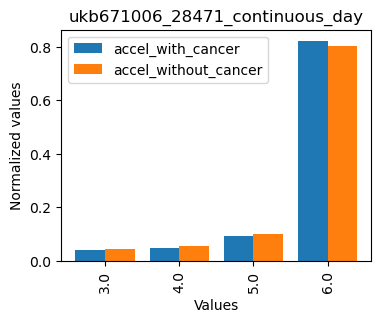


ukb671006_28473_sex
p-value: 0.12836002457427576


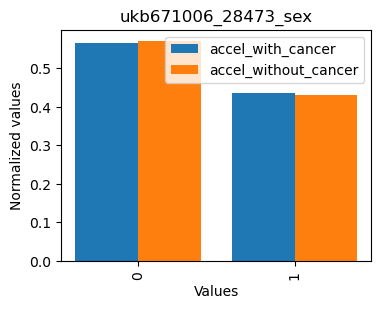


ukb671006_28474_cluster
p-value: 4.422416297189522e-14


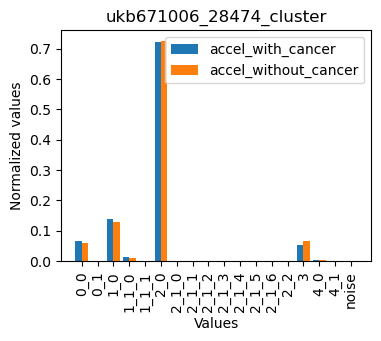


ukb671006_28475_group_eid_old
p-value: 8.466961879142603e-17


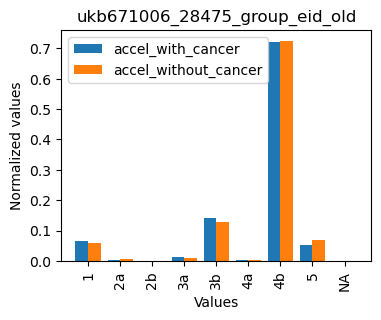


ukb671006_28476_abnormal_group_eid_old
p-value: 5.389878249642532e-08


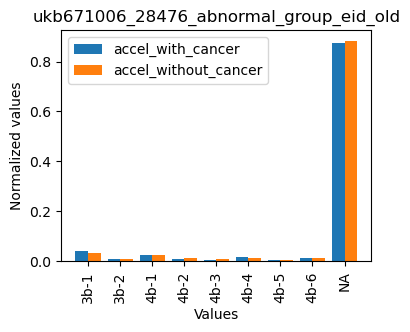


ukb671006_28480_group_five
p-value: 2.0069817260884273e-17


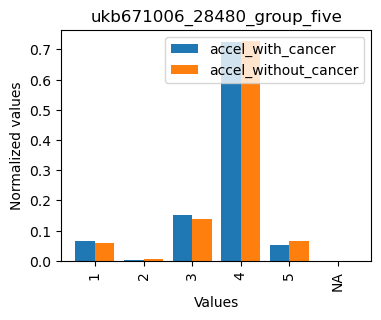

In [443]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_with_cancer, df_accel_without_cancer, 
                    "accel_with_cancer", "accel_without_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_categorical_with_without.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28449_day_num
p-value: 0.0003633525940662679


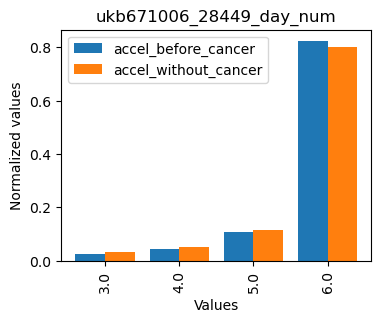


ukb671006_28471_continuous_day
p-value: 0.00019961636037819065


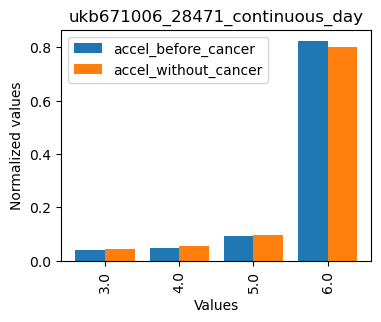


ukb671006_28473_sex
p-value: 6.988449211101014e-42


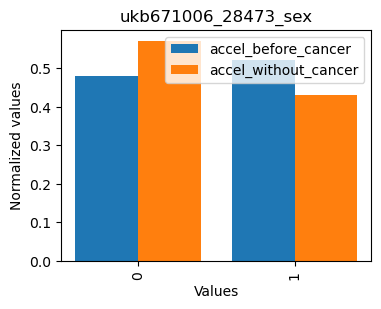


ukb671006_28474_cluster
p-value: 0.00033169697625045046


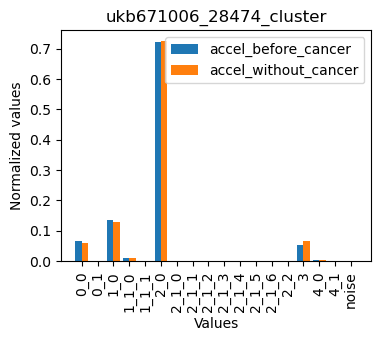


ukb671006_28475_group_eid_old
p-value: 1.1053747224001379e-05


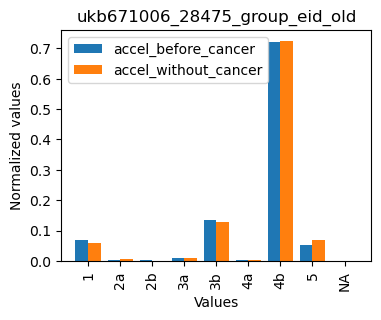


ukb671006_28476_abnormal_group_eid_old
p-value: 0.0004029354025918469


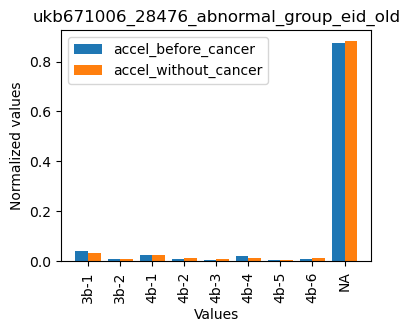


ukb671006_28480_group_five
p-value: 3.662836129630427e-05


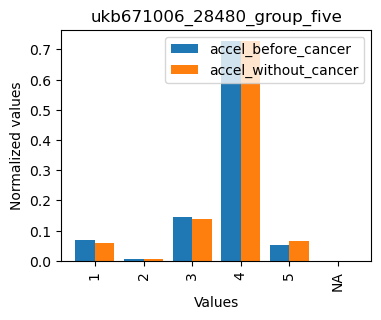

In [449]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_before_cancer, df_accel_without_cancer, 
                    "accel_before_cancer", "accel_without_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_categorical_before_without.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28449_day_num
p-value: 1.986226056324279e-05


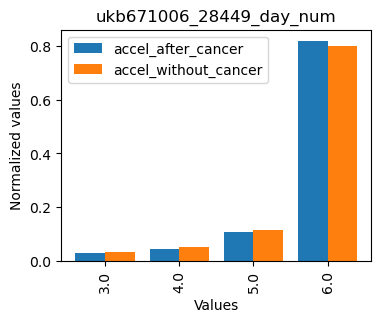


ukb671006_28471_continuous_day
p-value: 8.944167282061107e-06


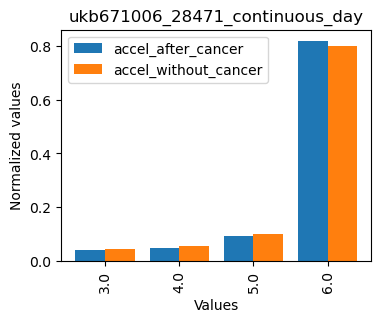


ukb671006_28473_sex
p-value: 6.578298422652438e-14


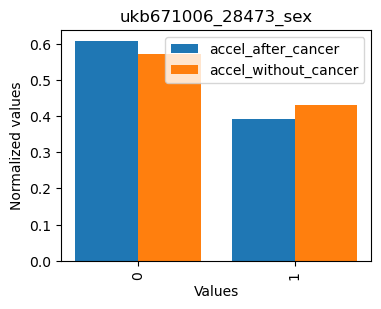


ukb671006_28474_cluster
p-value: 8.864980620204277e-11


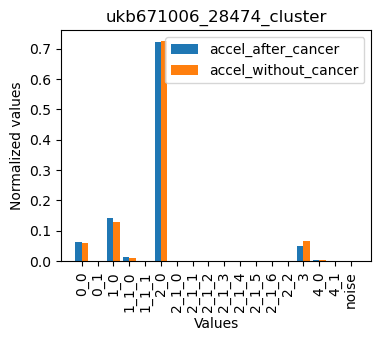


ukb671006_28475_group_eid_old
p-value: 1.5642668208274272e-13


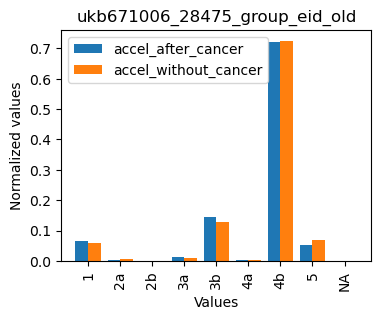


ukb671006_28476_abnormal_group_eid_old
p-value: 1.0266787336518013e-05


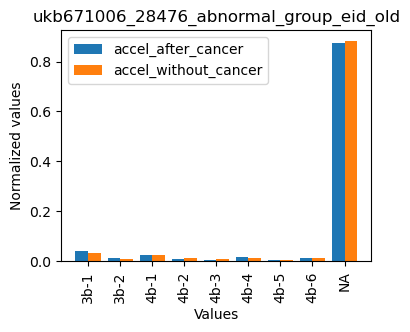


ukb671006_28480_group_five
p-value: 1.2717799856361914e-14


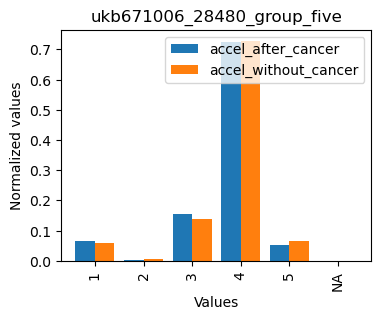

In [448]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_after_cancer, df_accel_without_cancer, 
                    "accel_after_cancer", "accel_without_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_categorical_after_without.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28450_ST_long_mean
p-value: 0.1593218362564855


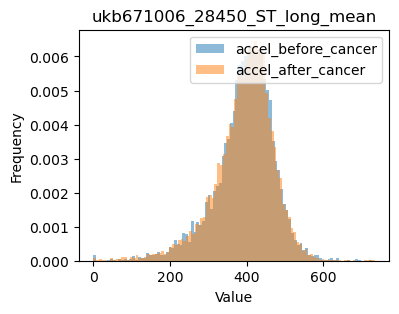

ukb671006_28451_ST_long_sd
p-value: 0.008212710295830698


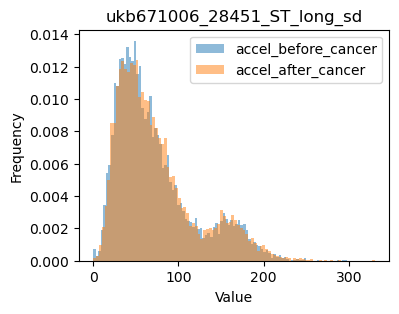

ukb671006_28452_WT_long_mean
p-value: 0.009801730214563915


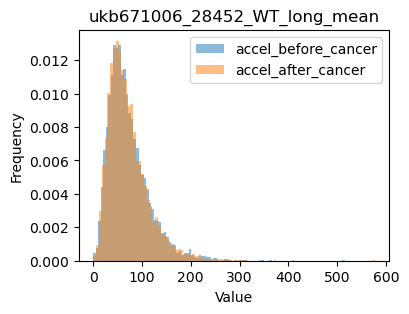

ukb671006_28453_WT_long_sd
p-value: 0.630486721774803


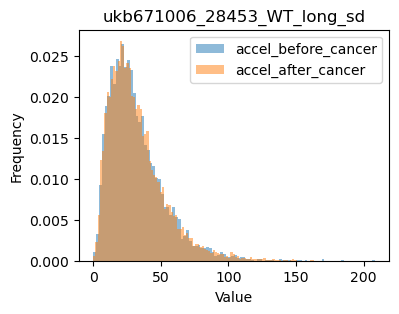

ukb671006_28454_ST_short_mean
p-value: 0.0008204868993333649


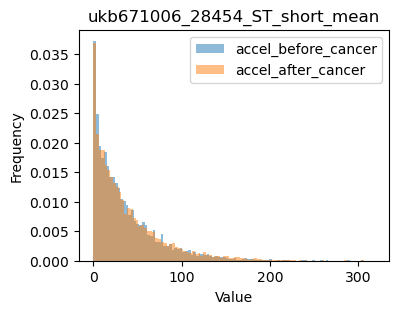

ukb671006_28455_ST_short_sd
p-value: 0.020688130247913956


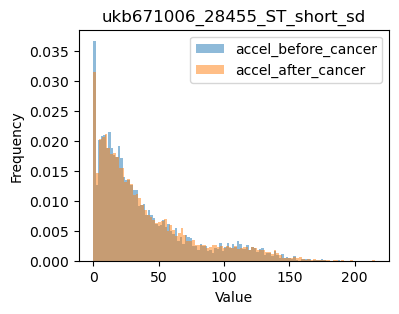

ukb671006_28456_WT_short_mean
p-value: 0.03391794413960482


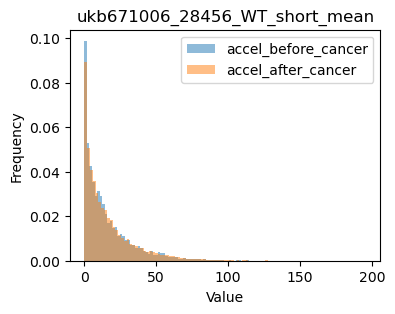

ukb671006_28457_WT_short_sd
p-value: 0.14048207027696785


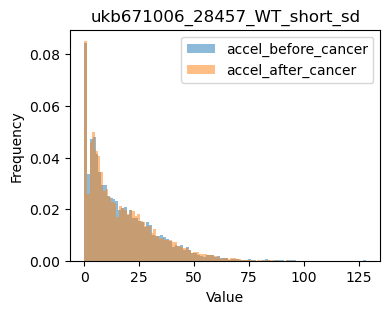

ukb671006_28458_long_window_len_mean
p-value: 0.09338265335288465


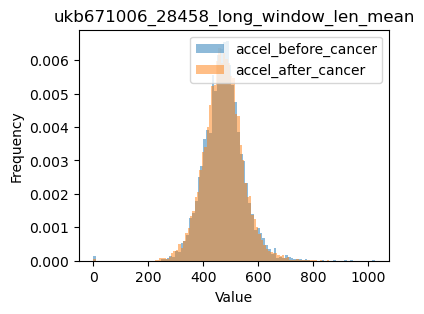

ukb671006_28459_long_window_len_sd
p-value: 0.80233814577903


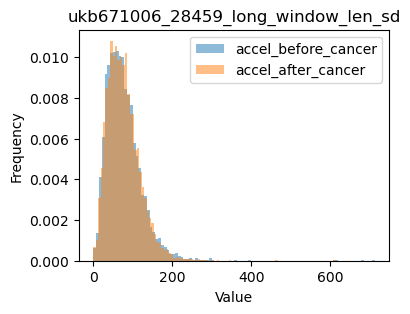

ukb671006_28460_long_window_num_mean
p-value: 0.11321237323372163


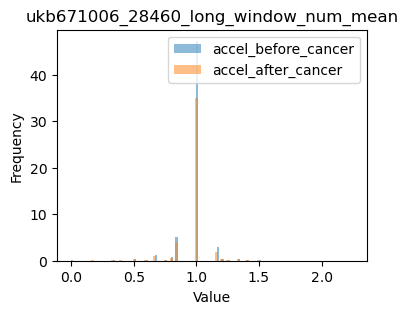

ukb671006_28461_long_window_num_sd
p-value: 0.26377651907267485


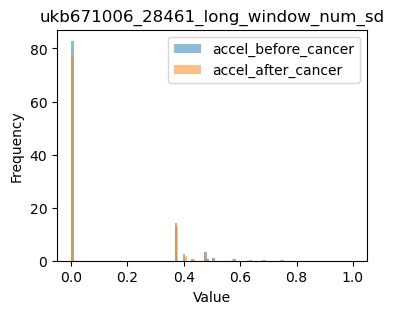

ukb671006_28462_short_window_len_mean
p-value: 0.2147983738942609


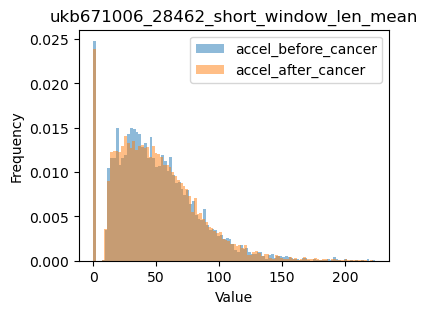

ukb671006_28463_short_window_len_sd
p-value: 0.3088546225285737


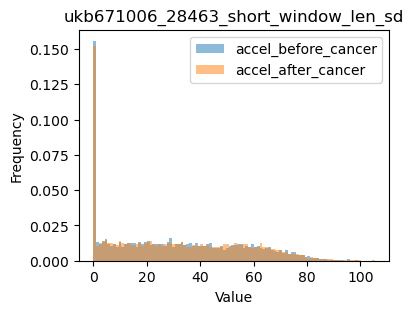

ukb671006_28464_short_window_num_mean
p-value: 0.0016010549711125682


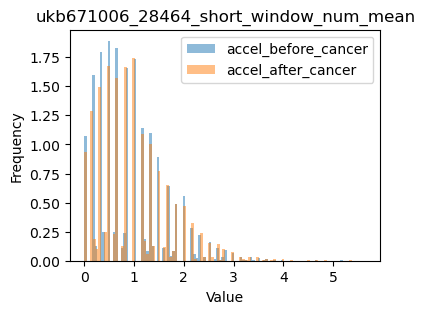

ukb671006_28465_short_window_num_sd
p-value: 0.012763553706400824


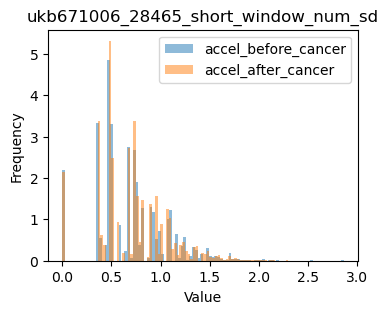

ukb671006_28466_phase_mean
p-value: 0.001983092358300134


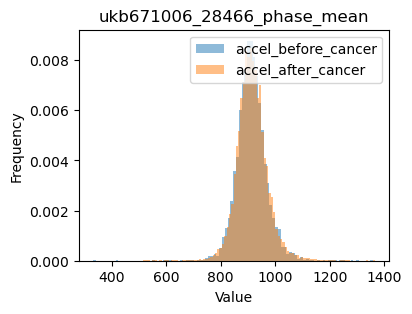

ukb671006_28467_phase_sd
p-value: 0.04221334667938191


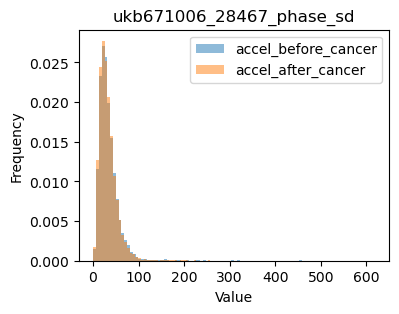

ukb671006_28468_max_period
p-value: 0.2162320069107569


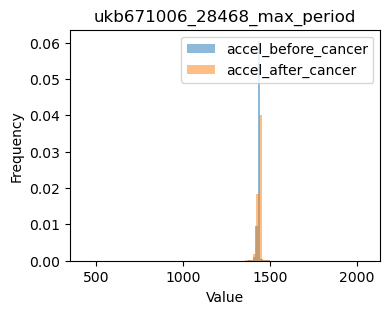

ukb671006_28469_amplitude
p-value: 0.2596789093113388


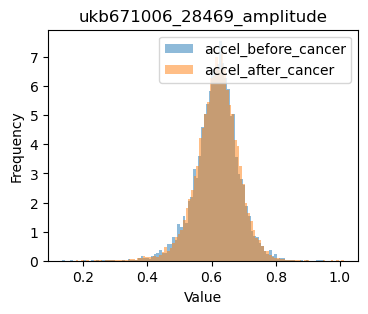

ukb671006_28470_sleep_percentage
p-value: 0.7886673228678831


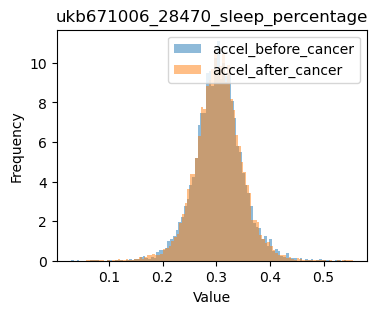

ukb671006_28472_age
p-value: 0.2585022541544264


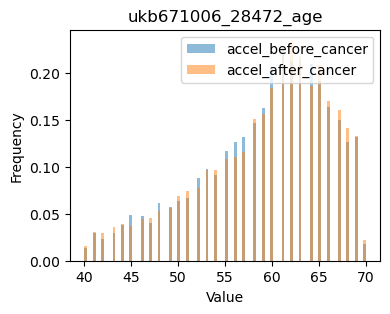

ukb671006_24430_90010-0.0_days
p-value: 7.717900752953971e-22


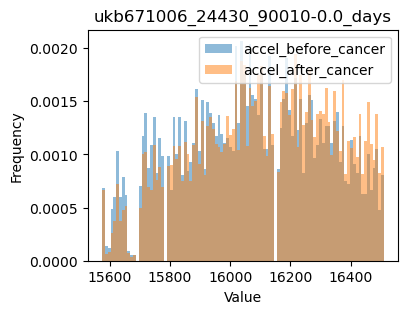

earliest_cancer_days
p-value: 0.0


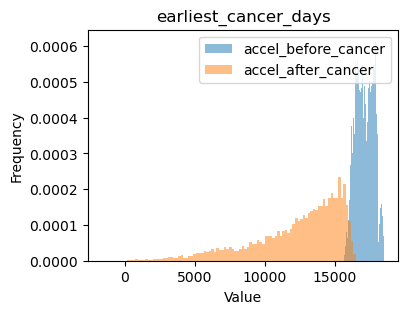

In [450]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_before_cancer, df_accel_after_cancer, 
                    "accel_before_cancer", "accel_after_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_continuous_before_after.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28450_ST_long_mean
p-value: 1.1525632978164698e-06


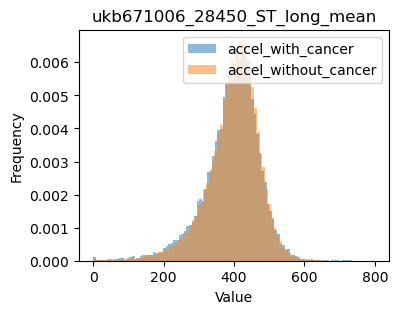

ukb671006_28451_ST_long_sd
p-value: 7.73418267121948e-05


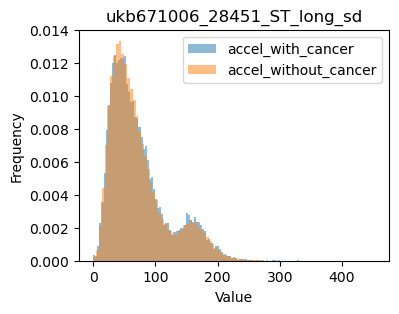

ukb671006_28452_WT_long_mean
p-value: 3.3020389526420435e-38


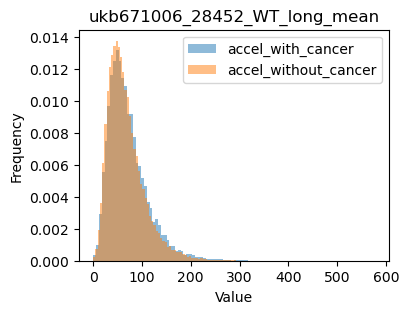

ukb671006_28453_WT_long_sd
p-value: 1.8839541073385369e-16


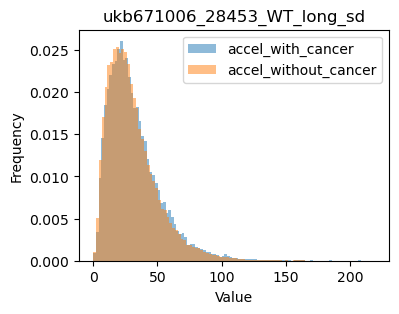

ukb671006_28454_ST_short_mean
p-value: 4.654876752193782e-34


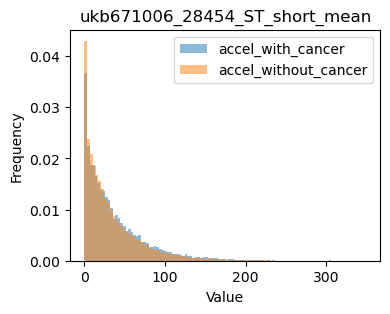

ukb671006_28455_ST_short_sd
p-value: 1.471224699324062e-16


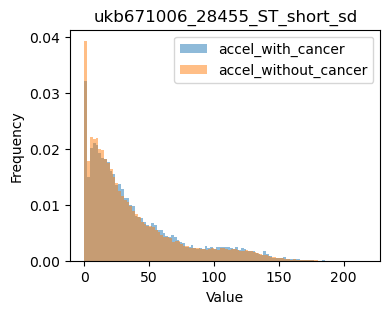

ukb671006_28456_WT_short_mean
p-value: 8.322503919842819e-32


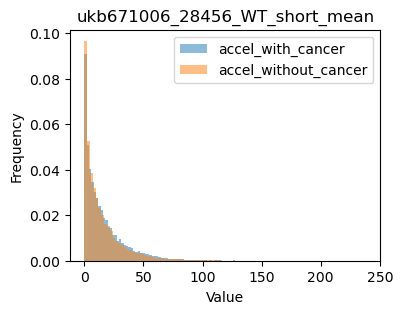

ukb671006_28457_WT_short_sd
p-value: 8.157149746750418e-19


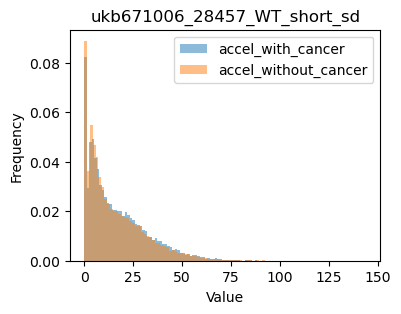

ukb671006_28458_long_window_len_mean
p-value: 0.003888814117328915


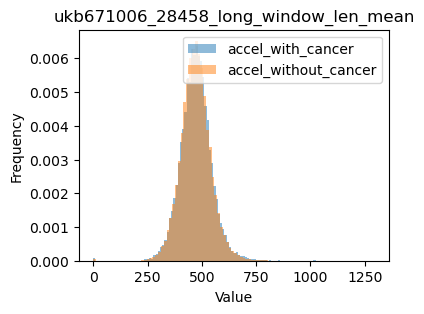

ukb671006_28459_long_window_len_sd
p-value: 3.9905851477881455e-06


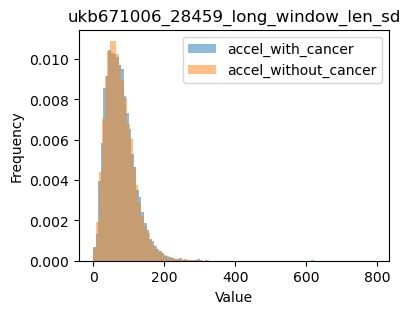

ukb671006_28460_long_window_num_mean
p-value: 0.07409972176762974


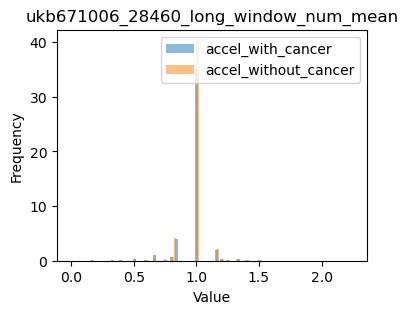

ukb671006_28461_long_window_num_sd
p-value: 4.307008209734589e-07


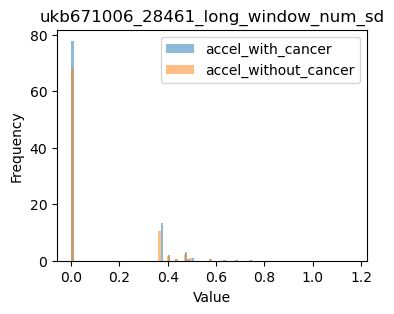

ukb671006_28462_short_window_len_mean
p-value: 1.1773831213326303e-06


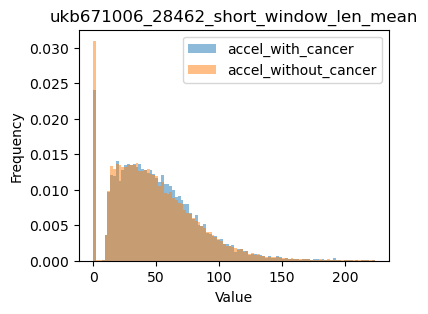

ukb671006_28463_short_window_len_sd
p-value: 1.8533463774477976e-19


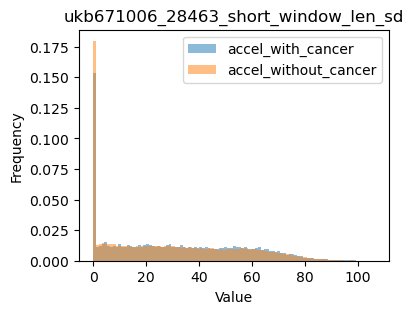

ukb671006_28464_short_window_num_mean
p-value: 1.0031392294830371e-56


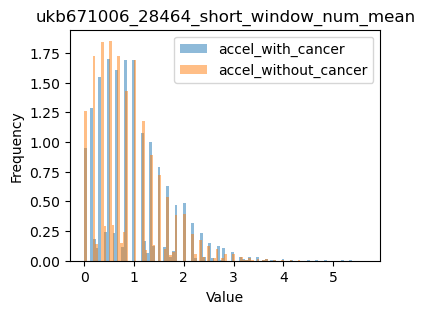

ukb671006_28465_short_window_num_sd
p-value: 4.745671384081316e-22


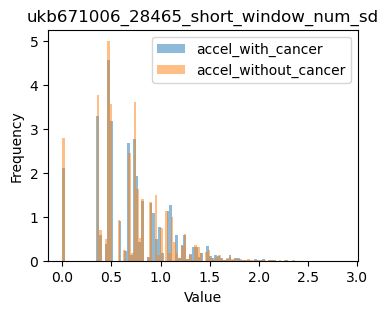

ukb671006_28466_phase_mean
p-value: 0.00014234588824797015


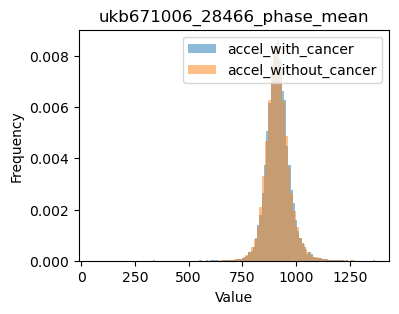

ukb671006_28467_phase_sd
p-value: 1.2123762883933315e-28


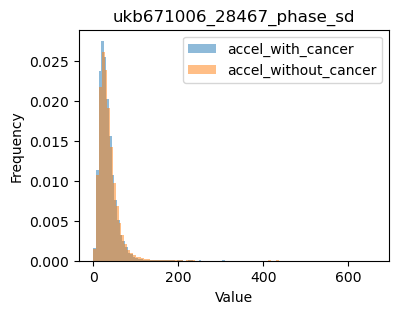

ukb671006_28468_max_period
p-value: 0.3714589668238123


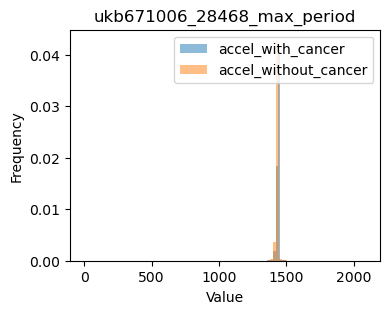

ukb671006_28469_amplitude
p-value: 0.22965765832205084


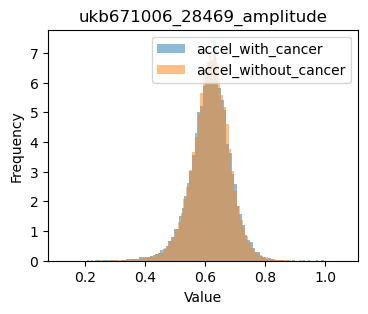

ukb671006_28470_sleep_percentage
p-value: 0.050630842649221214


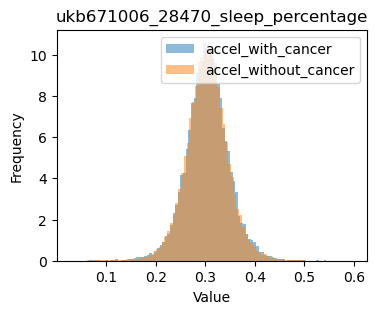

ukb671006_28472_age
p-value: 0.0


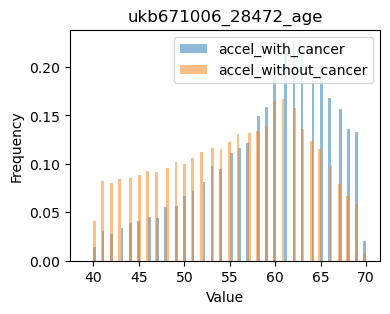

ukb671006_24430_90010-0.0_days
p-value: 0.7147393630924019


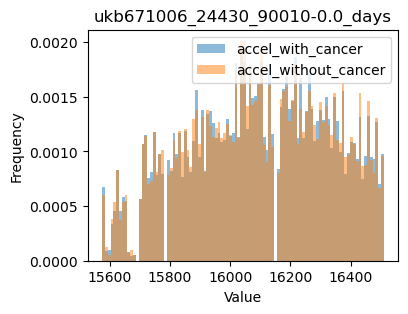

earliest_cancer_days
Skip because the matching data does not exist in both datasets


In [451]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_with_cancer, df_accel_without_cancer, 
                    "accel_with_cancer", "accel_without_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_continuous_with_without.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28450_ST_long_mean
p-value: 0.046664050552411754


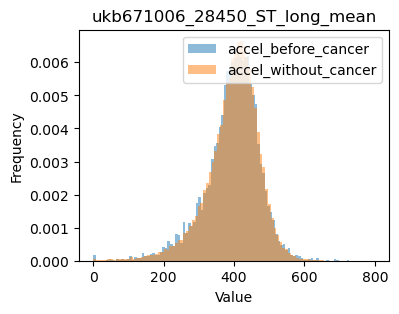

ukb671006_28451_ST_long_sd
p-value: 0.6495736873280111


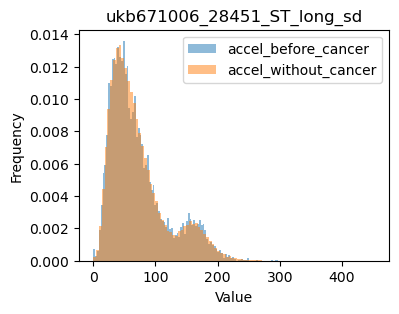

ukb671006_28452_WT_long_mean
p-value: 9.307550507126096e-23


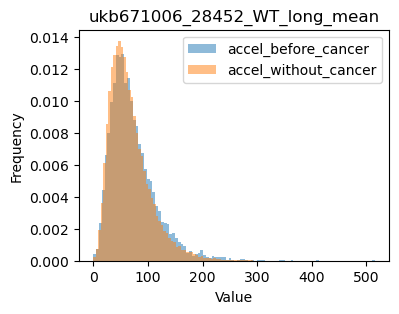

ukb671006_28453_WT_long_sd
p-value: 1.50272196462525e-06


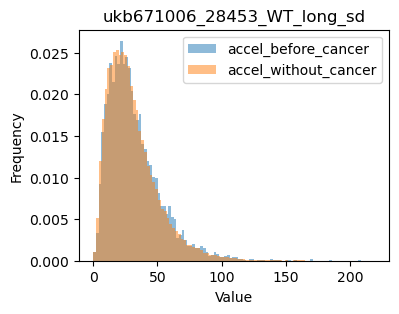

ukb671006_28454_ST_short_mean
p-value: 1.3749601401380153e-07


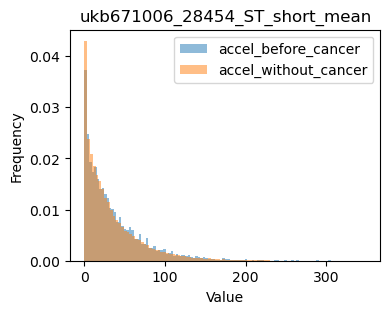

ukb671006_28455_ST_short_sd
p-value: 0.0005244761452606871


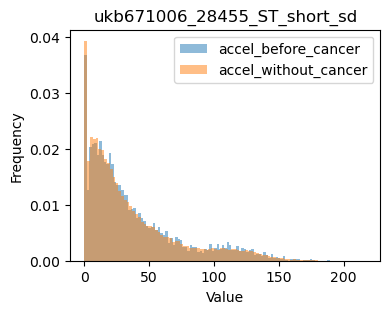

ukb671006_28456_WT_short_mean
p-value: 5.516361246730286e-09


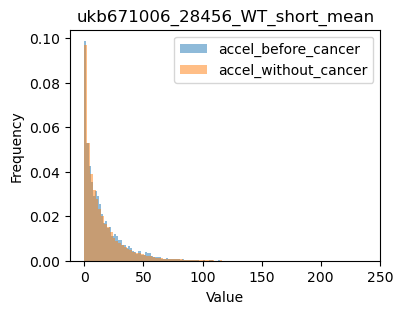

ukb671006_28457_WT_short_sd
p-value: 7.501027697754011e-06


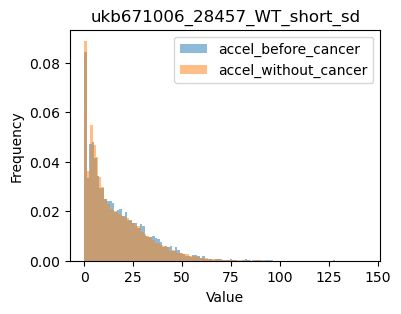

ukb671006_28458_long_window_len_mean
p-value: 0.002103946545836377


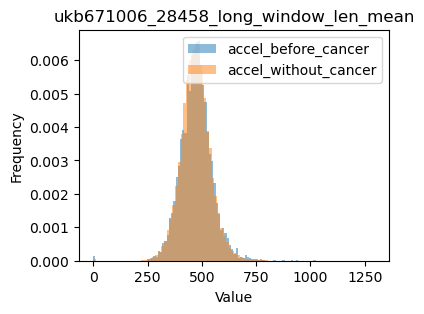

ukb671006_28459_long_window_len_sd
p-value: 0.003431531548429051


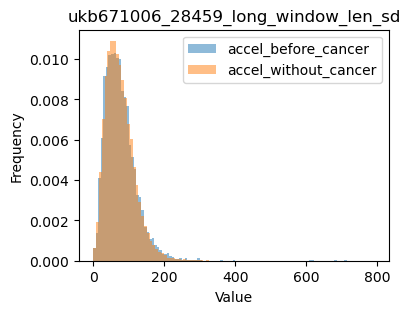

ukb671006_28460_long_window_num_mean
p-value: 0.9159188986911087


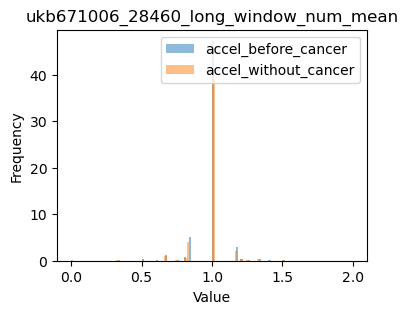

ukb671006_28461_long_window_num_sd
p-value: 0.018598158590027725


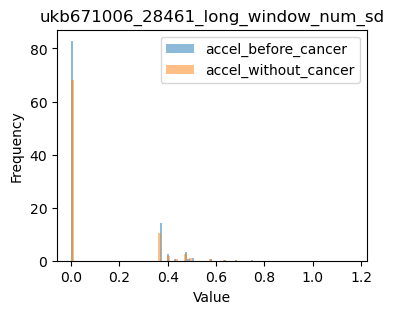

ukb671006_28462_short_window_len_mean
p-value: 0.032727606055241644


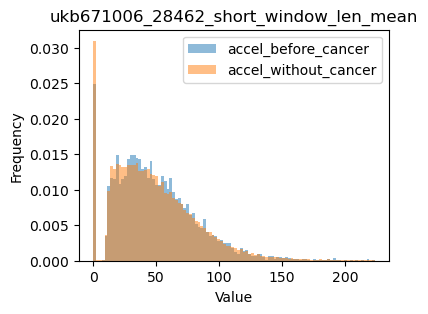

ukb671006_28463_short_window_len_sd
p-value: 8.363837645746545e-07


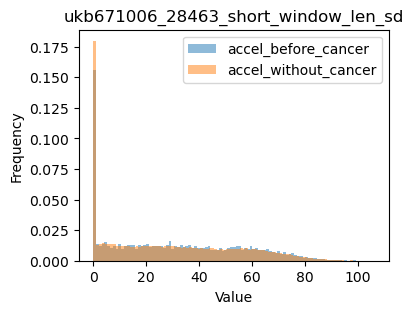

ukb671006_28464_short_window_num_mean
p-value: 8.331763755642811e-15


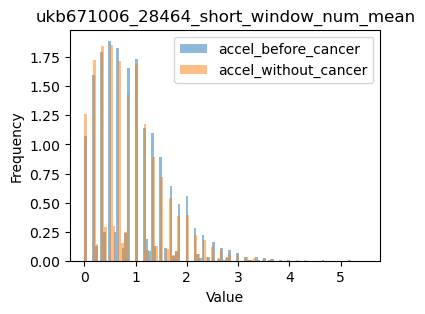

ukb671006_28465_short_window_num_sd
p-value: 2.538547694803001e-05


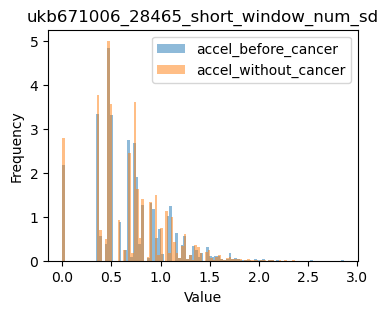

ukb671006_28466_phase_mean
p-value: 0.9736853556406284


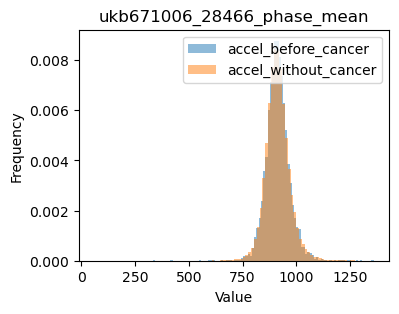

ukb671006_28467_phase_sd
p-value: 1.796726666623714e-07


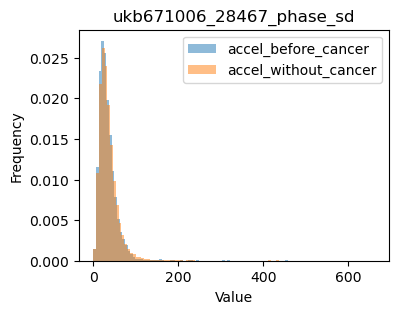

ukb671006_28468_max_period
p-value: 0.11323972670370895


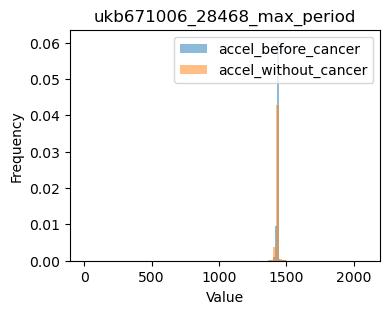

ukb671006_28469_amplitude
p-value: 0.10437321009612854


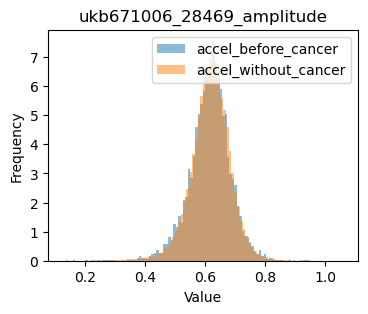

ukb671006_28470_sleep_percentage
p-value: 0.31073074127805633


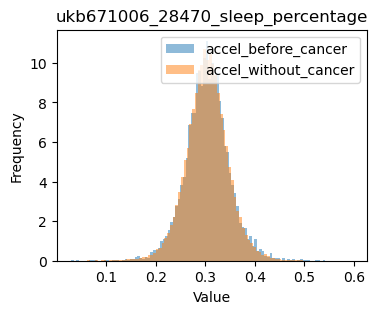

ukb671006_28472_age
p-value: 3.704606437540118e-293


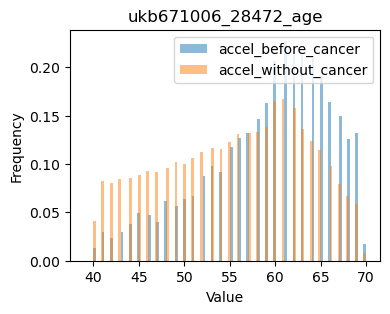

ukb671006_24430_90010-0.0_days
p-value: 6.654115361715239e-13


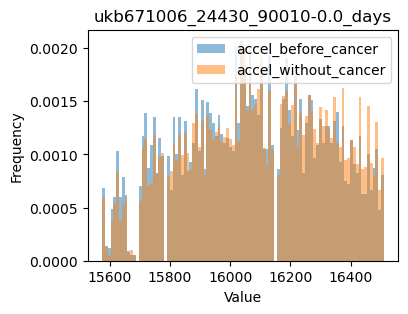

earliest_cancer_days
Skip because the matching data does not exist in both datasets


In [452]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_before_cancer, df_accel_without_cancer, 
                    "accel_before_cancer", "accel_without_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_continuous_before_without.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

ukb671006_28450_ST_long_mean
p-value: 1.3839321815947151e-06


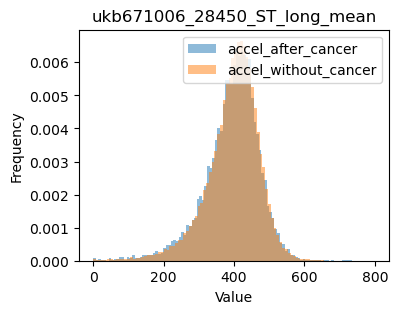

ukb671006_28451_ST_long_sd
p-value: 2.157630420265982e-06


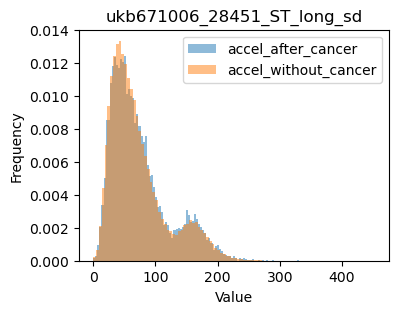

ukb671006_28452_WT_long_mean
p-value: 1.3324934092331647e-21


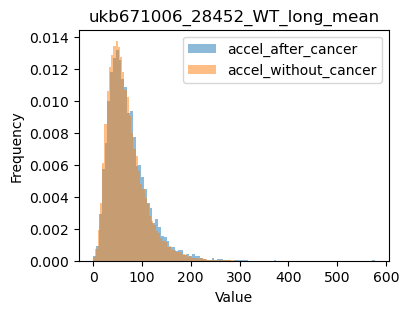

ukb671006_28453_WT_long_sd
p-value: 6.90542995143959e-13


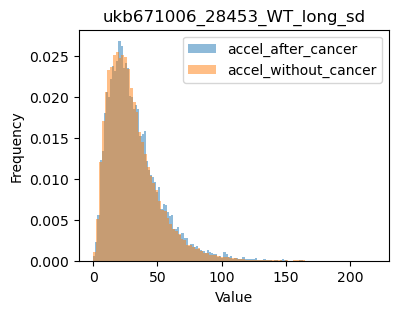

ukb671006_28454_ST_short_mean
p-value: 4.0553949100786423e-32


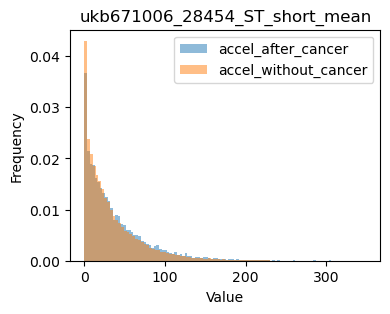

ukb671006_28455_ST_short_sd
p-value: 3.870733286658508e-16


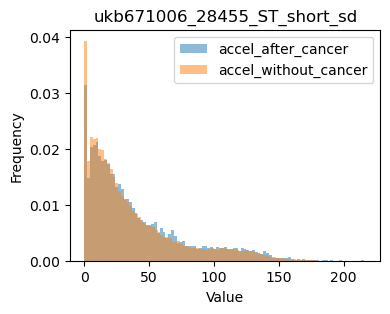

ukb671006_28456_WT_short_mean
p-value: 1.1705858328156657e-27


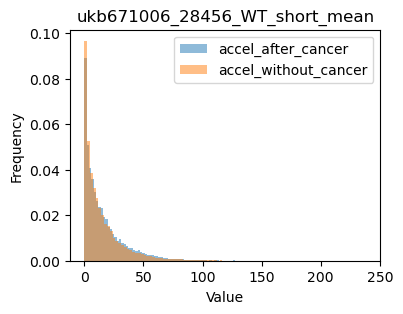

ukb671006_28457_WT_short_sd
p-value: 1.982009610108011e-16


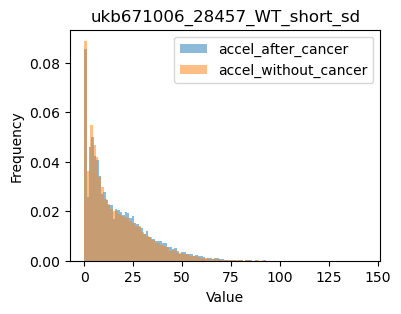

ukb671006_28458_long_window_len_mean
p-value: 0.12763514707508417


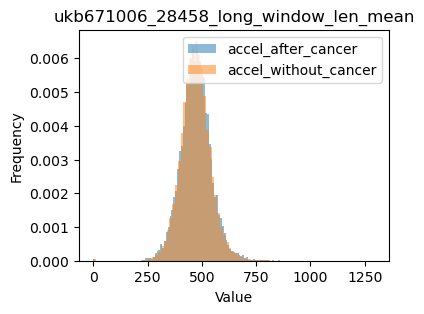

ukb671006_28459_long_window_len_sd
p-value: 0.00011691502272207131


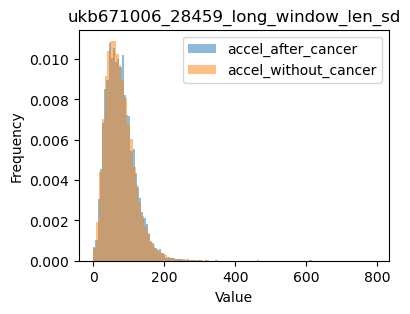

ukb671006_28460_long_window_num_mean
p-value: 0.019749741227510623


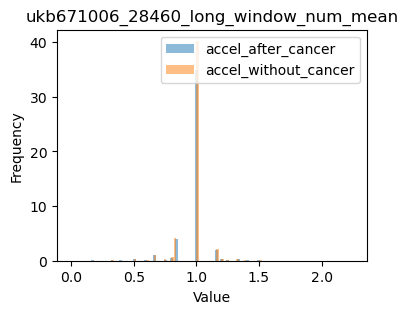

ukb671006_28461_long_window_num_sd
p-value: 1.4226896290854179e-06


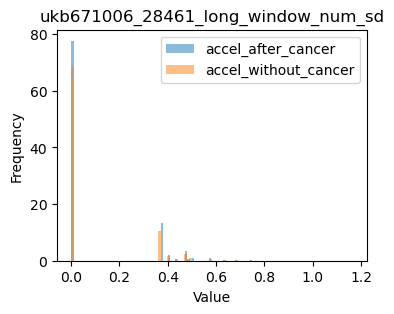

ukb671006_28462_short_window_len_mean
p-value: 1.961566893788802e-06


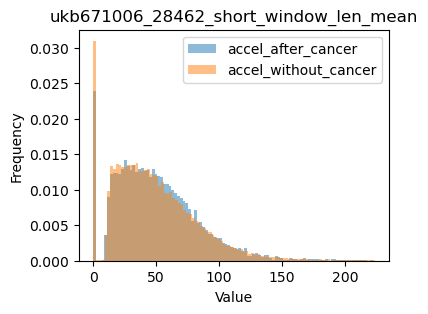

ukb671006_28463_short_window_len_sd
p-value: 3.6002597770807206e-16


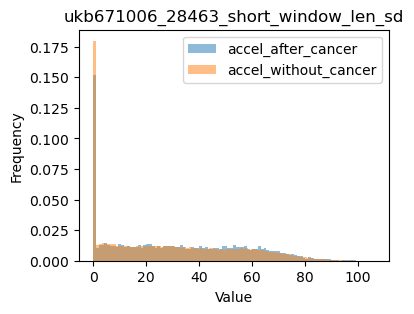

ukb671006_28464_short_window_num_mean
p-value: 1.3140032390079486e-49


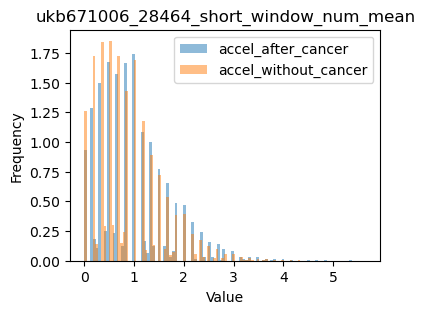

ukb671006_28465_short_window_num_sd
p-value: 3.9673278754285034e-21


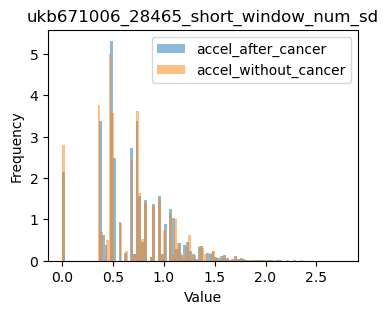

ukb671006_28466_phase_mean
p-value: 1.1735391342554674e-06


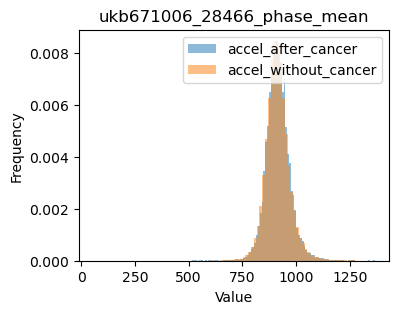

ukb671006_28467_phase_sd
p-value: 4.185587267833493e-28


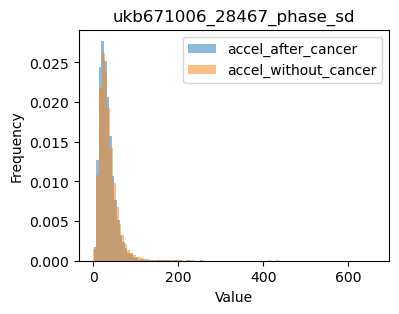

ukb671006_28468_max_period
p-value: 0.908126093565113


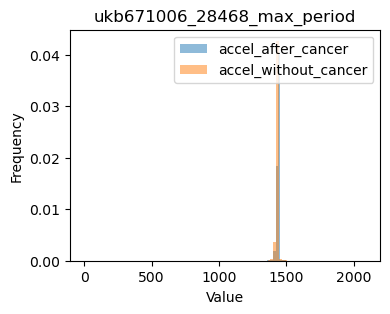

ukb671006_28469_amplitude
p-value: 0.6894477451945987


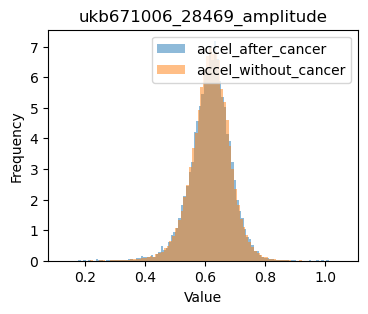

ukb671006_28470_sleep_percentage
p-value: 0.07234555418347374


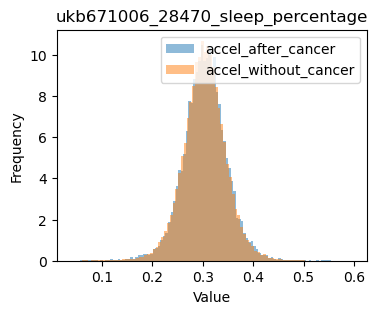

ukb671006_28472_age
p-value: 0.0


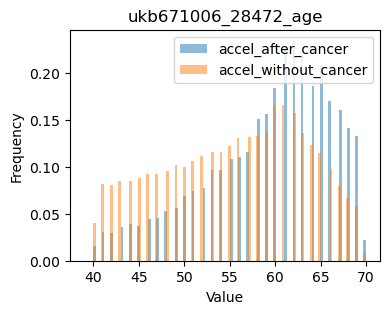

ukb671006_24430_90010-0.0_days
p-value: 3.660619155257749e-08


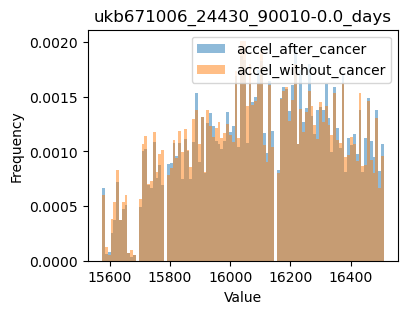

earliest_cancer_days
Skip because the matching data does not exist in both datasets


In [453]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_after_cancer, df_accel_without_cancer, 
                    "accel_after_cancer", "accel_without_cancer")

FILE_OUT = os.path.join(DIR_OUT, "compare_continuous_after_without.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(list_statistics)

## Enlarge

In [464]:
def plot_continuous_enlarge(df1, df2, pheno, list_range):
    # Calculate mean, median, and standard deviation for the two dataframes
    try:
        np_before = pl_to_float(df1[pheno])
        np_after = pl_to_float(df2[pheno])
        np_before = np_before[~np.isnan(np_before)]
        np_after = np_after[~np.isnan(np_after)]
    except:
        print("Skip because the matching data does not exist in both datasets")
        exit

    if len(np_before) < 10:
        print("Skip because the matching data does not exist in both datasets")
        exit
    if len(np_after) < 10:
        print("Skip because the matching data does not exist in both datasets")
        exit

    mean_before = np_before.mean()
    median_before = np.median(np_before)
    std_before = np_before.std()

    mean_after = np_after.mean()
    median_after = np.median(np_after)
    std_after = np_after.std()

    # Plot the distribution of the pheno column for each dataframe
    plt.figure(figsize=[4, 3])
    plt.xlim(list_range[0], list_range[1]) 
    plt.hist(np_before, alpha=0.5, label="accel before cancer", density=True, bins=100)
    plt.hist(np_after, alpha=0.5, label="accel without cancer", density=True, bins=100)
    plt.legend(loc="upper right")
    plt.title(pheno)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

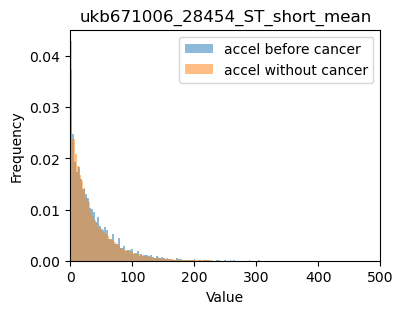

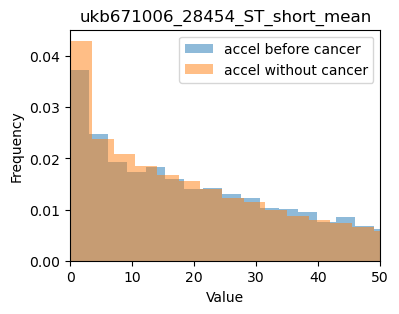

In [466]:
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, "ukb671006_28454_ST_short_mean", [0,500])
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, "ukb671006_28454_ST_short_mean", [0,50])

# Comparison per sub-divisions
Compare:
- Groups:
  - accel before cancer
  - accel without cancer
- Among:
  - Clusters
  - Sleep indexes

In [423]:
mm("""
graph LR;
    classDef class1 fill:#FFFFFF,stroke:#CCCCCC,color:#BBBBBB
    
    cancer_before[cancer before accel]:::class1 -.-> ACCEL[ACCEL cluster 1];
    ACCEL --> cancer_after[cancer after accel];
    ACCEL --> nocancer[no cancer record]
""")

mm("""
graph LR;
    classDef class1 fill:#FFFFFF,stroke:#CCCCCC,color:#BBBBBB
    
    cancer_before[cancer before accel]:::class1 -.-> ACCEL[ACCEL cluster 2];
    ACCEL --> cancer_after[cancer after accel];
    ACCEL --> nocancer[no cancer record]
""")

mm("""
graph LR;
    classDef class1 fill:#FFFFFF,stroke:#CCCCCC,color:#BBBBBB
    
    cancer_before[cancer before accel]:::class1 -.-> ACCEL[ACCEL cluster 3];
    ACCEL --> cancer_after[cancer after accel];
    ACCEL --> nocancer[no cancer record]
""")

print()
print()
print()
print()

mm("""
graph LR;
    classDef class_big font-size:15px,font-weight:bold
    classDef class_small font-size:12px
    
    ACCEL1[ACCEL cluster X] --> cancer_after1[cancer record]:::class_big;
    ACCEL1 --> nocancer1[no cancer record]:::class_small;

    ACCEL2[ACCEL cluster Y] --> cancer_after2[cancer record]:::class_small;
    ACCEL2 --> nocancer2[no cancer record]:::class_big;
""")

print()
print()
print()
print()

mm("""
graph LR;
    classDef class_big font-size:15px,font-weight:bold
    classDef class_small font-size:12px
    
    ACCEL1[ACCEL index A is high] --> cancer_after1[cancer record]:::class_big;
    ACCEL1 --> nocancer1[no cancer record]:::class_small;

    ACCEL2[ACCEL index A is low] --> cancer_after2[cancer record]:::class_small;
    ACCEL2 --> nocancer2[no cancer record]:::class_big;
""")

print()
print()
print()
print()


pheno, p-value: ukb671006_28449_day_num 0.00036335259406626883


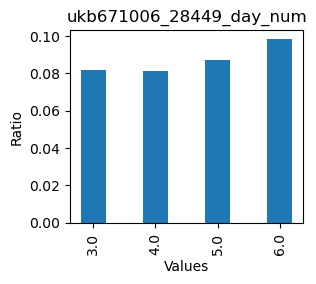

pheno, p-value: ukb671006_28471_continuous_day 0.00019961636037819065


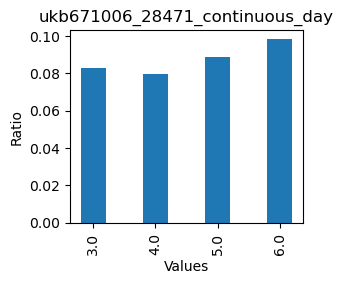

pheno, p-value: ukb671006_28473_sex 6.988449211101014e-42


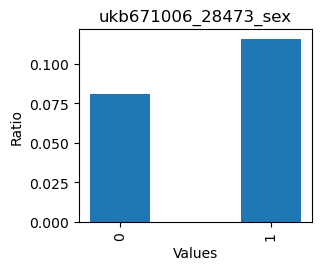

pheno, p-value: ukb671006_28474_cluster 0.0003978387340715889


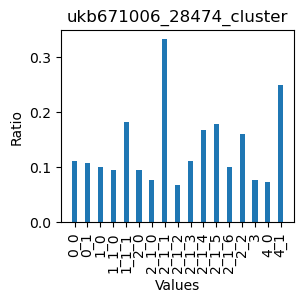

pheno, p-value: ukb671006_28475_group_eid_old 1.1286388887091419e-05


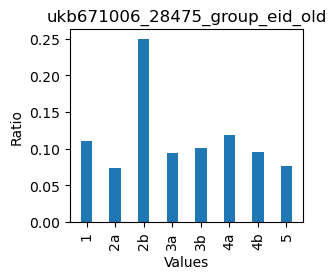

pheno, p-value: ukb671006_28476_abnormal_group_eid_old 0.0004029354025918467


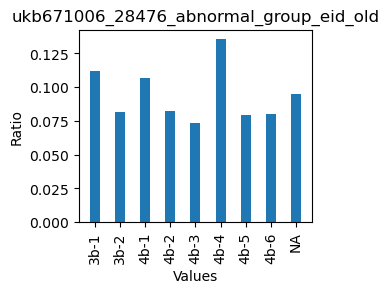

pheno, p-value: ukb671006_28480_group_five 3.357571472246521e-05


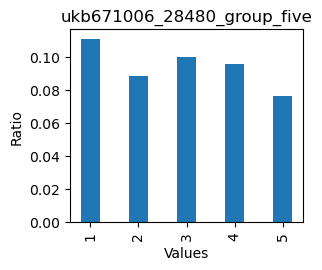

In [396]:
for pheno in pheno_list_categorical:
    #print(pheno)
    
    # List up the frequency of each value
    freq1 = df_accel_before_cancer[pheno].value_counts().rename({"counts": "with_cancer"})
    freq2 = df_accel_without_cancer[pheno].value_counts().rename({"counts": "without_cancer"})

    # Create a contingency table of the frequencies
    cont_table = (freq1.join(freq2, on=pheno, how='outer')
                  .with_column((pl.col("with_cancer") / pl.col("without_cancer")).alias("ratio")
                              )
                  .sort(by=pheno)
                  .drop_nulls()
                 )
    
    # Perform the chi-squared test of independence
    chi2, p_value, dof, expected = chi2_contingency(cont_table[["with_cancer", "without_cancer"]])

    # Print the results of the test
    print("pheno, p-value:", pheno, p_value)

    cont_table = cont_table.drop(["with_cancer", "without_cancer"])
        
    # Create a bar chart of the normalized data
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 2.5)
    plt.title(pheno)
    ax.bar(np.arange(cont_table.shape[0]), cont_table["ratio"], width=0.4)
    ax.set_xticks(np.arange(cont_table.shape[0]))
    ax.set_xticklabels(cont_table[pheno], rotation='vertical')
    ax.set_xlabel("Values")
    ax.set_ylabel("Ratio")
    plt.show()

## See what's inside Cluster 2b

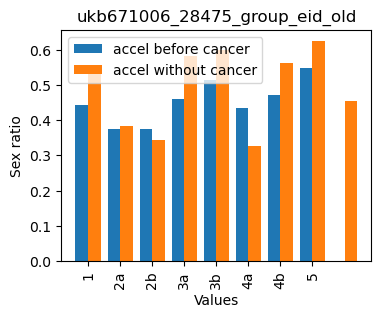

In [405]:
# pheno = "ukb671006_28475_group_eid_old"

# set_label = set(df_accel_before_cancer[pheno]) | set(df_accel_without_cancer[pheno])

def func_ratio_sex(df, pheno_sex, pheno2):
   # Returns a Polars.DataFrame of
    # sex ratio among different pheno2
    # (pheno_sex denotes the name of sex phenotype)
    sex_1 = (df
             .groupby(pl.col([pheno_sex, pheno2]))
             .count()
             .sort(by=[pheno_sex, pheno2])
            )

    sex_ratio_0 = sex_1.filter(pl.col(pheno_sex) == "0")
    sex_ratio_1 = sex_1.filter(pl.col(pheno_sex) == "1")

    cont_table = (sex_ratio_0
                  .with_columns(sex_ratio_1["count"]
                                .alias("count1"))
                 )
    
    ratio_table = (cont_table
                   .with_columns((pl.col("count") / (pl.col("count") + pl.col("count1")))
                                 .alias("ratio"))
                   .drop([pheno_sex, "count", "count1"])
                  )
    return cont_table, ratio_table

cont_table_before_cancer, sex_ratio_before_cancer = func_ratio_sex(df_accel_before_cancer, 
               "ukb671006_28473_sex", "ukb671006_28475_group_eid_old")
cont_table_without_cancer, sex_ratio_without_cancer = func_ratio_sex(df_accel_without_cancer, 
               "ukb671006_28473_sex", "ukb671006_28475_group_eid_old")


ticks = sex_ratio_before_cancer["ukb671006_28475_group_eid_old"]

# Create a bar chart of the normalized data
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
plt.title("ukb671006_28475_group_eid_old")

ax.bar(np.arange(sex_ratio_before_cancer.shape[0]) - 0.2,
       sex_ratio_before_cancer[:, 1], width=0.4, label="accel before cancer")

ax.bar(np.arange(sex_ratio_without_cancer.shape[0]) + 0.2,
       sex_ratio_without_cancer[:, 1], width=0.4, label="accel without cancer")

ax.set_xticks(np.arange(sex_ratio_before_cancer.shape[0]))
ax.set_xticklabels(ticks, rotation='vertical')
ax.set_xlabel("Values")
ax.set_ylabel("Sex ratio")
ax.legend()

plt.show()

print()

In [406]:
cont_table_before_cancer

ukb671006_28473_sex,ukb671006_28475_group_eid_old,count,count1
str,str,u32,u32
"""0""","""1""",186,233
"""0""","""2a""",9,15
"""0""","""2b""",3,5
"""0""","""3a""",30,35
"""0""","""3b""",425,399
"""0""","""4a""",10,13
"""0""","""4b""",2085,2323
"""0""","""5""",179,148


# Propensity score matching
https://www.dskomei.com/entry/2020/05/18/234407

In [306]:
df_comparison = pl.concat([
    df_accel_before_cancer.with_column(pl.Series([1] * len(df_accel_before_cancer)).alias("cancer")),
    df_accel_without_cancer.with_column(pl.Series([0] * len(df_accel_without_cancer)).alias("cancer"))
])
df_comparison

shape: (69812, 40)
┌─────────┬───────────────────────────┬─────────────────────────┬─────────────────────────┬─────┬────────────────────┬────────────────────────────────┬──────────────────────┬────────┐
│ eid     ┆ ukb671006_24430_90010-0.0 ┆ ukb671006_28448_eid_old ┆ ukb671006_28449_day_num ┆ ... ┆ accel_after_cancer ┆ ukb671006_24430_90010-0.0_days ┆ earliest_cancer_days ┆ cancer │
│ ---     ┆ ---                       ┆ ---                     ┆ ---                     ┆     ┆ ---                ┆ ---                            ┆ ---                  ┆ ---    │
│ i64     ┆ str                       ┆ str                     ┆ str                     ┆     ┆ bool               ┆ i64                            ┆ i64                  ┆ i64    │
╞═════════╪═══════════════════════════╪═════════════════════════╪═════════════════════════╪═════╪════════════════════╪════════════════════════════════╪══════════════════════╪════════╡
│ 1000337 ┆ 2014-11-15                ┆ 5579755                 ┆ 6.0                     ┆ ... ┆ false              ┆ 16107                          ┆ 16613                ┆ 1      │
│ 1002455 ┆ 2013-07-20                ┆ 4988731                 ┆ 6.0                     ┆ ... ┆ false              ┆ 15624                          ┆ 17654                ┆ 1      │
│ 1002651 ┆ 2013-07-20                ┆ 2962276                 ┆ 6.0                     ┆ ... ┆ false              ┆ 15624                          ┆ 15956                ┆ 1      │
│ 1002720 ┆ 2014-11-15                ┆ 2112328                 ┆ 6.0                     ┆ ... ┆ false              ┆ 16107                          ┆ 17458                ┆ 1      │
│ ...     ┆ ...                       ┆ ...                     ┆ ...                     ┆ ... ┆ ...                ┆ ...                            ┆ ...                  ┆ ...    │
│ 6024605 ┆ 2013-08-02                ┆ 1910696                 ┆ 6.0                     ┆ ... ┆ null               ┆ 15637                          ┆ null                 ┆ 0      │
│ 6024698 ┆ 2013-07-22                ┆ 1252952                 ┆ 5.0                     ┆ ... ┆ null               ┆ 15626                          ┆ null                 ┆ 0      │
│ 6024737 ┆ 2014-06-09                ┆ 4741522                 ┆ 6.0                     ┆ ... ┆ null               ┆ 15948                          ┆ null                 ┆ 0      │
│ 6024818 ┆ 2014-11-15                ┆ 6016103                 ┆ 3.0                     ┆ ... ┆ null               ┆ 16107                          ┆ null                 ┆ 0      │
└─────────┴───────────────────────────┴─────────────────────────┴─────────────────────────┴─────┴────────────────────┴────────────────────────────────┴──────────────────────┴────────┘

limit_output extension: Maximum message size of 10000 exceeded with 30700 characters

In [314]:
# https://zenn.dev/s1ok69oo/articles/c058108acb83e7
def func_propensity_match(df, x_names, y_name, z_name, z_subdivision, step=0.1):
    # 傾向スコアを算出するために使用する説明変数
    X = df[x_names].astype(float)
    X = sm.add_constant(X)
    # 処置変数
    if z_subdivision == "": # Continuous variable
        D = df[z_name].astype(float)
    else: # Categorical variable
        D = (df[z_name] == z_subdivision)

    # 傾向スコアを算出
    model = sm.Logit(D, X)
    result = model.fit()

    df["propensity_score"] = result.predict(X)

    scores = np.arange(0, 1, step)
    match_arr = np.array([])
    
    for score in scores:
        _df = df[(df["propensity_score"] >= score) & 
                 (df["propensity_score"] < score+step)]
        tmp0 = np.array(_df[_df[z_name] != z_subdivision]["cancer"])
        tmp1 = np.array(_df[_df[z_name] == z_subdivision]["cancer"])
        if (tmp0.size!=0) and (tmp1.size!=0):
            match_arr = np.append(match_arr, tmp1.mean() - tmp0.mean())

    return match_arr.mean()

In [236]:
pheno_list_categorical = [
"ukb671006_28474_cluster",
"ukb671006_28475_group_eid_old",
"ukb671006_28476_abnormal_group_eid_old",
"ukb671006_28480_group_five",]

result = []

for pheno in pheno_list_categorical:
    for z_subdivision in set(df_comparison[pheno]):
        with redirect_stdout(StringIO()): # Suppress output inside the function
            try:
                ATE = func_propensity_match(df_comparison.to_pandas(),
                                      x_names=['ukb671006_28472_age','ukb671006_28473_sex', 
                                               'ukb671006_28449_day_num', 'ukb671006_28471_continuous_day'],
                                      y_name='cancer',
                                      z_name=pheno,
                                      z_subdivision=z_subdivision
                )
            except Exception as e:
                ATE = "failed"
                print(e)
        print("Pheno =", pheno, "subdivision =", z_subdivision, "ATE =", ATE)
        result.append([pheno, z_subdivision, ATE])
    print()
    
FILE_OUT = os.path.join(DIR_OUT, "AdjustedTreatmentEffect_categorical.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(result)

Pheno = ukb671006_28474_cluster subdivision = 0_1 ATE = 0.0094336917562724


G:\linux\conda\envs\py3-202303\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pheno = ukb671006_28474_cluster subdivision = noise ATE = -0.0873764149591632


G:\linux\conda\envs\py3-202303\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pheno = ukb671006_28474_cluster subdivision = 2_1_4 ATE = 0.055513829340919085
Pheno = ukb671006_28474_cluster subdivision = 2_1_6 ATE = 0.0035607721170965306
Pheno = ukb671006_28474_cluster subdivision = 2_1_0 ATE = -0.015942688289706103
Pheno = ukb671006_28474_cluster subdivision = 1_1_1 ATE = 0.06650965905396486
Pheno = ukb671006_28474_cluster subdivision = 2_1_5 ATE = 0.06419661728565554
Pheno = ukb671006_28474_cluster subdivision = 1_0 ATE = -0.0014341361604202664
Pheno = ukb671006_28474_cluster subdivision = 2_0 ATE = 0.0004707364547825929
Pheno = ukb671006_28474_cluster subdivision = 3 ATE = -0.02051022668478956
Pheno = ukb671006_28474_cluster subdivision = 1_1_0 ATE = -0.0012698982614131882
Pheno = ukb671006_28474_cluster subdivision = 2_2 ATE = 0.05060317526203151
Pheno = ukb671006_28474_cluster subdivision = 2_1_1 ATE = 0.16267908309455587


G:\linux\conda\envs\py3-202303\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pheno = ukb671006_28474_cluster subdivision = 2_1_3 ATE = 0.012652932580728346
Pheno = ukb671006_28474_cluster subdivision = 2_1_2 ATE = -0.02485457619347814
Pheno = ukb671006_28474_cluster subdivision = 0_0 ATE = 0.013472143059606909
Pheno = ukb671006_28474_cluster subdivision = 4_1 ATE = 0.1127157025740985
Pheno = ukb671006_28474_cluster subdivision = 4_0 ATE = -0.019458602496746705

Pheno = ukb671006_28475_group_eid_old subdivision = 2a ATE = -0.019458602496746705
Pheno = ukb671006_28475_group_eid_old subdivision = 1 ATE = 0.013433721522655512


G:\linux\conda\envs\py3-202303\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pheno = ukb671006_28475_group_eid_old subdivision = NA ATE = -0.0873764149591632
Pheno = ukb671006_28475_group_eid_old subdivision = 4a ATE = 0.019191982084964435
Pheno = ukb671006_28475_group_eid_old subdivision = 5 ATE = -0.02051022668478956
Pheno = ukb671006_28475_group_eid_old subdivision = 3b ATE = -0.0011725005408828384
Pheno = ukb671006_28475_group_eid_old subdivision = 2b ATE = 0.1127157025740985
Pheno = ukb671006_28475_group_eid_old subdivision = 3a ATE = -0.0012698982614131882
Pheno = ukb671006_28475_group_eid_old subdivision = 4b ATE = 0.0004707364547825929

Pheno = ukb671006_28476_abnormal_group_eid_old subdivision = 4b-5 ATE = -0.013601567469959733
Pheno = ukb671006_28476_abnormal_group_eid_old subdivision = NA ATE = 0.013669644425694204
Pheno = ukb671006_28476_abnormal_group_eid_old subdivision = 4b-6 ATE = -0.01332075518381158
Pheno = ukb671006_28476_abnormal_group_eid_old subdivision = 4b-3 ATE = -0.01359704985832996
Pheno = ukb671006_28476_abnormal_group_eid_old subdiv

G:\linux\conda\envs\py3-202303\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pheno = ukb671006_28480_group_five subdivision = NA ATE = -0.0873764149591632
Pheno = ukb671006_28480_group_five subdivision = 5 ATE = -0.02051022668478956
Pheno = ukb671006_28480_group_five subdivision = 4 ATE = 0.002128530334763429
Pheno = ukb671006_28480_group_five subdivision = 3 ATE = -0.00372645258535158



In [351]:
pheno_list_continuous = [
"ukb671006_28450_ST_long_mean",
"ukb671006_28451_ST_long_sd",
"ukb671006_28452_WT_long_mean",
"ukb671006_28453_WT_long_sd",
"ukb671006_28454_ST_short_mean",
"ukb671006_28455_ST_short_sd",
"ukb671006_28456_WT_short_mean",
"ukb671006_28457_WT_short_sd",
"ukb671006_28458_long_window_len_mean",
"ukb671006_28459_long_window_len_sd",
"ukb671006_28460_long_window_num_mean",
"ukb671006_28461_long_window_num_sd",
"ukb671006_28462_short_window_len_mean",
"ukb671006_28463_short_window_len_sd",
"ukb671006_28464_short_window_num_mean",
"ukb671006_28465_short_window_num_sd",
"ukb671006_28466_phase_mean",
"ukb671006_28467_phase_sd",
"ukb671006_28468_max_period",
"ukb671006_28469_amplitude",
"ukb671006_28470_sleep_percentage",
"ukb671006_28472_age",
"ukb671006_24430_90010-0.0_days",
"earliest_cancer_days",
]

result = []


# https://zenn.dev/s1ok69oo/articles/c058108acb83e7
def func_propensity_match(df, x_names, y_name, z_name, z_subdivision, step=0.1):
    # 傾向スコアを算出するために使用する説明変数
    X = df[x_names].astype(float)
    X = sm.add_constant(X)
    # 処置変数
    if z_subdivision == "": # Continuous variable
        D = df[z_name].astype(float)
        D = (D > np.median(D))
        df["surrogate"] = D
    else: # Categorical variable
        D = (df[z_name] == z_subdivision)
        
    # 傾向スコアを算出
    model = sm.Logit(D, X)
    result = model.fit()

    df["propensity_score"] = result.predict(X)

    scores = np.arange(0, 1, step)
    match_arr = np.array([])

    for score in scores:
        _df = df[(df["propensity_score"] >= score) & 
                 (df["propensity_score"] < score+step)]
        if z_subdivision == "": # Continuous variable
            tmp0 = np.array(_df[_df["surrogate"] == False]["cancer"])
            tmp1 = np.array(_df[_df["surrogate"] == True]["cancer"])
        else: # Categorical variable
            tmp0 = np.array(_df[_df[z_name] != z_subdivision]["cancer"])
            tmp1 = np.array(_df[_df[z_name] == z_subdivision]["cancer"])
        if (tmp0.size!=0) and (tmp1.size!=0):
            match_arr = np.append(match_arr, tmp1.mean() - tmp0.mean())

    return match_arr.mean()


for pheno in pheno_list_continuous:
    try:
        with redirect_stdout(StringIO()): # Suppress output inside the function
            ATE = func_propensity_match(df_comparison.to_pandas(),
                                  x_names=['ukb671006_28472_age','ukb671006_28473_sex', 
                                           'ukb671006_28449_day_num', 'ukb671006_28471_continuous_day'],
                                  y_name='cancer',
                                  z_name=pheno,
                                  z_subdivision=""
            )
    except Exception as e:
        ATE = "failed"
        print()
        print(e)
    print("Pheno =", pheno, "ATE =", ATE)
    result.append([pheno, z_subdivision, ATE])

    
FILE_OUT = os.path.join(DIR_OUT, "AdjustedTreatmentEffect_continuous.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(result)

Pheno = ukb671006_28450_ST_long_mean ATE = -0.00033726813440217857
Pheno = ukb671006_28451_ST_long_sd ATE = 7.161208795699453e-05
Pheno = ukb671006_28452_WT_long_mean ATE = 0.0061282200595172455
Pheno = ukb671006_28453_WT_long_sd ATE = -0.006705419337262113
Pheno = ukb671006_28454_ST_short_mean ATE = 0.0020841443965672474
Pheno = ukb671006_28455_ST_short_sd ATE = -0.0003602193746466472
Pheno = ukb671006_28456_WT_short_mean ATE = 0.004525889639455254
Pheno = ukb671006_28457_WT_short_sd ATE = -0.01494769912486118
Pheno = ukb671006_28458_long_window_len_mean ATE = 0.007557266811262266
Pheno = ukb671006_28459_long_window_len_sd ATE = -0.0043283160923445795
Pheno = ukb671006_28460_long_window_num_mean ATE = 0.012515313414074164
Pheno = ukb671006_28461_long_window_num_sd ATE = 0.002378614881057079
Pheno = ukb671006_28462_short_window_len_mean ATE = 0.03518882686520157
Pheno = ukb671006_28463_short_window_len_sd ATE = 0.006107462010132957
Pheno = ukb671006_28464_short_window_num_mean ATE = 0.

G:\linux\conda\envs\py3-202303\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



Perfect separation detected, results not available
Pheno = ukb671006_28472_age ATE = failed

Perfect separation detected, results not available
Pheno = ukb671006_24430_90010-0.0_days ATE = failed

Perfect separation detected, results not available
Pheno = earliest_cancer_days ATE = failed
